In [4]:
import math
import numpy as np
import pandas as pd
import xarray as xr

from glob import glob

from numba import jit
import dask

import matplotlib.pyplot as plt

## Dask cluster

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="4GB",
    walltime="00:20:00",
)

cluster.scale(jobs=10)

In [3]:
# print(cluster.job_script())

In [4]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.157:36975,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Setup

In [74]:
################
## Model code ##
################

@jit(nopython=True)
def simulate_water_balance_loop(
    Ws_frac_init,
    Wi_init,
    Sp_init,
    P,
    T,
    Ts,
    Tm,
    rootDepth_oGS,
    rootDepth_GS_factor,
    awCap,
    wilting_point,
    GS_start,
    GS_length,
    lai,
    Kc,
    alpha,
    beta_HBV,
    phi,
    doy,
):
    """
    Inputs:
     - Ws_frac_init: initial soil moisture content []
     - Wi_init: initial canopy water storage [mm]
     - Sp_init: initial snowpack [mm]
     - Wg_init: initial groundwater [mm]
     - P: daily precipitation timeseries [mm]
     - T: daily mean temperature timeseries [C]
     - Ts: snowfall threshold [C]
     - Tm: snowmelt threshold [C]
     - rootDepth_oGS: root depth outside the growing season [mm]
     - rootDepth_GS: root depth during the growing season [mm]
     - awCap: available water capacity [mm/m]
     - wilting_point: wilting point as fraction of Wcap []
     - GS_start: planting day / start of growing season []
     - GS_length: length of growing season []
     - Kc: crop scalar factor timeseries []
     - lai: leaf area index timeseries []
     - alpha: drying function scale parameter []
     - beta_HBV: HBV direct recharge parameter []
     - phi: Latitude [deg]
     - doy: day of year []

    Outputs:
     - Ws: daily soil moisture content timeseries [mm]
     - Ws_frac: daily soil moisture fraction timeseries []
    """
    def calculate_potential_evapotranspiration(T, N, phi):
        """
        Inputs:
         - T: daily mean temperature [C]
         - N: day of year
         - phi: latitude [deg]
        Outputs:
         - daily potential evapotranspiration calculated via the Hamon method [mm]
        Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
        """
        
        # Calculate solar declination (delta)
        delta = -23.44 * math.cos(math.radians((360 / 365) * (N + 10)))
        
        # Calculate fractional day length (Lambda)
        Lambda = (1 / math.pi) * math.acos(
            -math.tan(math.radians(phi)) * math.tan(math.radians(delta))
        )
        
        # Calculate saturation vapor pressure
        if T > 0:
            Psat = 0.61078 * math.exp((17.26939 * T) / (T + 237.3))
        else:
            Psat = 0.61078 * math.exp((21.87456 * T) / (T + 265.5))
        
        # Calculate saturation vapor density (rho_sat)    
        rho_sat = (2.167 * Psat) / (T + 273.15)
        
        # Calculate potential evapotranspiration (PET)
        PET = 330.2 * Lambda * rho_sat
        
        return PET

    ##################################
    # Initialization
    ##################################
    # Simulation dimensions
    nx, ny, nt = T.shape
    
    # Soil moisture capacity
    Wcap = np.empty((nx,ny,366))

    # Soil moisture capacity
    for ix in range(nx):
        for iy in range(ny):
            for t in range(366):
                if (t < GS_start[ix,iy]) or (t > (GS_start[ix,iy] + GS_length[ix,iy])):
                    # outside GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * rootDepth_oGS[ix,iy] / 1000
                else:
                    # during GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * (rootDepth_GS_factor[ix,iy] * rootDepth_oGS[ix,iy]) / 1000

    # Soil moisture [mm]
    Ws = np.empty_like(T)
    Ws[:,:,0] = Ws_frac_init * Wcap[:,:,0]

    # Soil moisture fraction
    Ws_frac = np.empty_like(T)
    Ws_frac[:,:,0] = Ws_frac_init
    
    # Canopy water storage
    Wi = np.empty((nx,ny,2))
    Wi[:,:,0] = Wi_init
    
    # Snowpack
    Sp = np.empty((nx,ny,2))
    Sp[:,:,0] = Sp_init

    ######################################
    # Begin simulation
    ######################################
    for ix in range(nx):
        for iy in range(ny):
            for t in range(1, nt):
                # t runs from 1 to n_sim
                # t2 and t2o are 0 or 1 oppositely (used for untracked variables)
                t2 = t % 2
                t2o = int(not(t2))
        
                ################
                # Snowfall
                ################
                # Precipitation is assumed to be entirely snow/rain
                # if temperature is below/above threshold (Ts)
                if T[ix,iy,t] < Ts:
                    Ps = P[ix,iy,t]
                    Pa = 0
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o] + Ps
                else:
                    Pa = P[ix,iy,t]
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o]
        
                ################
                # Snowmelt
                ################
                # Snowmelt is assumed to occur if temperature
                # is above a threshold (Tm), but is limited to
                # the volume of the snowpack
                if T[ix,iy,t] > Tm:
                    Ms = 2.63 + 2.55 * T[ix,iy,t] + 0.0912 * T[ix,iy,t] * Pa
                    if Ms > Sp[ix,iy,t2]:
                        Ms = Sp[ix,iy,t2]
                        Sp[ix,iy,t2] = 0
                    else:
                        Sp[ix,iy,t2] = Sp[ix,iy,t2] - Ms
                else:
                    Ms = 0.0

                #########################
                # Canopy & throughfall
                #########################
                # Maximum canopy storage scales with LAI
                Wi_max = 0.25 * lai[ix,iy,doy[t]]

                # Open water evaporation rate assumed to be PET
                Eow = calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                # Canopy evaporation
                Ec = Eow * ((Wi[ix,iy,t2o] / Wi_max) ** 0.6666667)

                # Throughfall is rainfall minus (canopy storage plus canopy evaporation)
                # Throughfall if zero if all rainfall goes to canopy
                if Wi_max < Pa + Wi[ix,iy,t2o] - Ec:
                    Pt = Pa - Ec - (Wi_max - Wi[ix,iy,t2o])
                else:
                    Pt = 0

                # Update canopy storage
                if Wi[ix,iy,t2o] + (Pa - Pt) - Ec <= Wi_max:
                    if Wi[ix,iy,t2o] + (Pa - Pt) - Ec > 0.0:
                        Wi[ix,iy,t2] = Wi[ix,iy,t2o] + (Pa - Pt) - Ec
                    else:
                        Wi[ix,iy,t2] = 0.0
                else:
                    Wi[ix,iy,t2] = Wi_max

                ########################
                # Evapotranspiration
                ########################
                # Potential ET scales with (annual) crop-specific coefficient
                PET = Kc[ix,iy,doy[t]] * calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                
                # Calculate actual evapotranspiration
                # Actual ET is limited by water availability (throughfall + snowmelt)
                # otherwise the difference is scaled by drying function
                if (Pt + Ms) >= PET:
                    AET = PET
                else:
                    g = (1 - math.exp(-alpha[ix,iy] * Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]])) / (1 - math.exp(-alpha[ix,iy]))
                    AET =  g * (PET - Pt - Ms)

                ################
                # Runoff
                ################
                # HBV direct groundwater recharge (can also be thought of as runoff)
                # scales nonlinearly with saturation in the active zone
                # Direct groundwater recharge (HBV)
                Id = (Pt + Ms) * (Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]]) ** beta_HBV
                
                ################
                # Soil moisture
                ################
                # Soil surplus is the leftover water after saturating soils
                # It gets partitioned to more runoff and groundwater recharge
                if Wcap[ix,iy,doy[t]] < Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET:
                    S = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - Wcap[ix,iy,doy[t]]
                else:
                    S = 0

                # Update soil moisture
                Ws[ix,iy,t] = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - S

                # Soil moisture must be positive
                if Ws[ix,iy,t] < 0:
                    Ws[ix,iy,t] = 0.0

                # Wilting point in mm
                wilting_point_mm = wilting_point[ix,iy] * Wcap[ix,iy,doy[t]]
                # Soil wetness
                Ws_frac[ix,iy,t] = (Ws[ix,iy,t] + wilting_point_mm) / (Wcap[ix,iy,doy[t]] + wilting_point_mm)
    
    # Return
    return Ws_frac #, Ws, Wcap, Ms_out, Sp, Pa_out, Ps_out #Wg, AET_out, PET_out, g_out, Sp, Pt_out, Wcap

## Precalibration

In [9]:
nldas_forcing_dir = '/storage/group/pches/default/public/NLDAS/forcing/daily'
project_dir = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

In [84]:
# Climate drivers from NLDAS
year = '201'
files = glob(f'{nldas_forcing_dir}/NLDAS_FORA0125_H.A{year}*.nc')
ds_nldas_forcing = xr.concat([xr.open_dataset(file) for file in files], dim='time')

In [87]:
# Geophysical inputs
ds_lai = xr.open_dataset(f'{project_dir}/WBM/geo_inputs/LAI_clima_NLDASgrid.nc')
ds_awCap = xr.open_dataset(f'{project_dir}/WBM/geo_inputs/NLDAS_NOAH_awCap.nc')
ds_wiltingp = xr.open_dataset(f'{project_dir}/WBM/geo_inputs/NLDAS_NOAH_wiltingp.nc')

In [88]:
# Grid attributes
nlat = len(ds_lai.lat)
nlon = len(ds_lai.lon)

In [89]:
# Spatially constant inputs
Ts = -1.             # Snowfall threshold
Tm = 1.              # Snowmelt threshold
Ws_frac_init = 0.5   # Initial soil moisture
Wi_init = 0.         # Initial canopy water storage
Sp_init = 0.         # Initial snowpack
alpha = 5            # Crop drying coefficient
beta_HBV = 2.        # HBV parameter

# Neglect influence of growing season for now
GS_start = 120
GS_length = 182
rootDepth_oGS = 1000
rootDepth_GS_factor = 1
Kc = 1

# Broadcast to grid if needed
grid = np.ones((nlon, nlat))

Ws_frac_init_in = Ws_frac_init * grid
Wi_init_in = Wi_init * grid
Sp_init_in = Sp_init * grid
alpha_in = alpha * grid
GS_start_in = GS_start * grid
GS_length_in = GS_length * grid
rootDepth_oGS_in = rootDepth_oGS * grid
rootDepth_GS_factor_in = rootDepth_GS_factor * grid

# Other inputs
tas_in = np.transpose(ds_nldas_forcing['TMP'].to_numpy(), (2,1,0))
prcp_in = np.transpose(ds_nldas_forcing['APCP'].to_numpy(), (2,1,0))

Kc_in = Kc * np.ones(prcp_in.shape)

In [90]:
# Forcing inputs
tas_in = np.transpose(ds_nldas_forcing['TMP'].to_numpy() - 273.15, (2,1,0))
prcp_in = np.transpose(ds_nldas_forcing['APCP'].to_numpy(), (2,1,0))

lai_in = np.transpose(ds_lai['LAI'].to_numpy(), (2,1,0))
awCap_in = np.transpose(ds_awCap['awCap'].to_numpy())
wiltingp_in = np.transpose(ds_wiltingp['wiltingp'].to_numpy())

In [91]:
%%time
out = simulate_water_balance_loop(
    Ws_frac_init = Ws_frac_init_in,
    Wi_init = Wi_init_in,
    Sp_init = Sp_init_in,
    P = prcp_in,
    T = tas_in,
    Ts = Ts,
    Tm = Tm,
    rootDepth_oGS = rootDepth_oGS_in,
    rootDepth_GS_factor = rootDepth_GS_factor_in,
    awCap = awCap_in,
    GS_start = GS_start_in,
    GS_length = GS_length_in,
    lai = lai_in,
    Kc = Kc_in,
    alpha = alpha_in,
    beta_HBV = beta_HBV,
    phi = ds_nldas_forcing.lat.to_numpy(),
    wilting_point = wiltingp_in,
    doy = ds_nldas_forcing.time.dt.dayofyear.to_numpy()-1)

CPU times: user 50.9 s, sys: 910 ms, total: 51.8 s
Wall time: 52.1 s


In [92]:
out.shape

(464, 224, 1461)

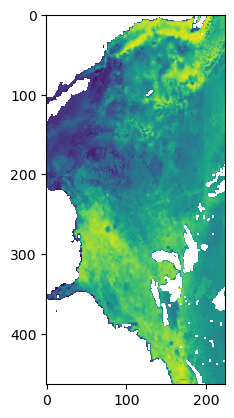

In [106]:
plt.imshow(out[:,:,100])